In [2]:
BATCH_SIZE = 48
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 9
MAX_TRAIN_EPOCHS = 99
AUGMENT_BRIGHTNESS = False

In [5]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
##from skimage.util import montage2d as montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '/input/airbus-ship-detection/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [6]:
masks = pd.read_csv('/input/airbus-ship-detection/train_ship_segmentations_v2.csv')
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


,ImageId,ships,has_ship,has_ship_vec,file_size_kb
162225,d7bcf5755.jpg,0,0.0,[0.0],107.096680
110423,92d7f8787.jpg,0,0.0,[0.0],220.242188
15934,152b9a228.jpg,0,0.0,[0.0],154.598633
145323,c13c061a1.jpg,0,0.0,[0.0],103.899414
15118,1415186e4.jpg,0,0.0,[0.0],210.781250
130223,ad20ee08e.jpg,1,1.0,[1.0],131.464844
186361,f7d12c543.jpg,1,1.0,[1.0],76.037109


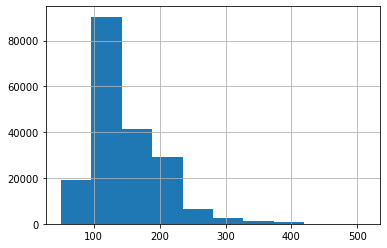

In [7]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

<AxesSubplot:>

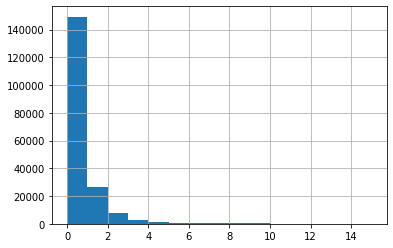

In [8]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

12788 masks


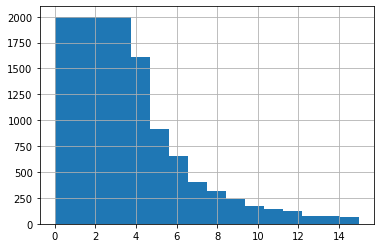

In [9]:
SAMPLES_PER_GROUP = 2000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [10]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

35364 training masks
8838 validation masks


In [11]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [12]:
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0 1


In [13]:
%%time
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(900, 256, 256, 3) (900, 256, 256, 1)
CPU times: user 15.2 s, sys: 3.41 s, total: 18.6 s
Wall time: 24.7 s


In [14]:
valid_y = valid_y.astype(np.float64)
print(valid_y.dtype,valid_x.dtype)

float64 float64


In [15]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')


# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

In [17]:
from keras import models, layers
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img

if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
# d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
# d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

2022-11-04 14:55:18.027877: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 256, 256, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 256, 256, 3)  0           average_pooling2d[0][0]          
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 3)  12          gaussian_noise[0][0]             
______________________________________________________________________________________________

In [36]:
import keras.backend as K
from keras.optimizers import adam_v2
from keras.losses import binary_crossentropy

    ##if np.max(y_true) == 0.0:
    ##    return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros

## intersection over union
def IoU(y_true, y_pred, eps=1e-6):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

In [37]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8)

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2,
                      patience=20) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [39]:

seg_model.compile(optimizer=adam_v2.Adam(1e-3, decay=1e-6), loss=IoU, metrics=['binary_accuracy'])
    
step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(train_df))
loss_history = [seg_model.fit(aug_gen,
                                 steps_per_epoch=step_count,
                                 ##epochs=MAX_TRAIN_EPOCHS,
                              epochs = 20,
                                 validation_data=(valid_x, valid_y),
                                 callbacks=callbacks_list,
                                workers=1 # the generator is not very thread safe
                                           )]

Epoch 1/20
9/9 [==============================] - 62s 7s/step - loss: -0.0090 - binary_accuracy: 0.4126 - val_loss: -0.0061 - val_binary_accuracy: 0.0495

Epoch 00001: val_loss improved from inf to -0.00606, saving model to seg_model_weights.best.hdf5
Epoch 2/20
9/9 [==============================] - 59s 7s/step - loss: -0.0095 - binary_accuracy: 0.5720 - val_loss: -0.0062 - val_binary_accuracy: 0.1216

Epoch 00002: val_loss improved from -0.00606 to -0.00617, saving model to seg_model_weights.best.hdf5
Epoch 3/20
9/9 [==============================] - 58s 7s/step - loss: -0.0299 - binary_accuracy: 0.7476 - val_loss: -0.0162 - val_binary_accuracy: 0.7524

Epoch 00003: val_loss improved from -0.00617 to -0.01617, saving model to seg_model_weights.best.hdf5
Epoch 4/20
9/9 [==============================] - 57s 7s/step - loss: -0.0900 - binary_accuracy: 0.8993 - val_loss: -0.0384 - val_binary_accuracy: 0.8589

Epoch 00004: val_loss improved from -0.01617 to -0.03841, saving model to seg_m

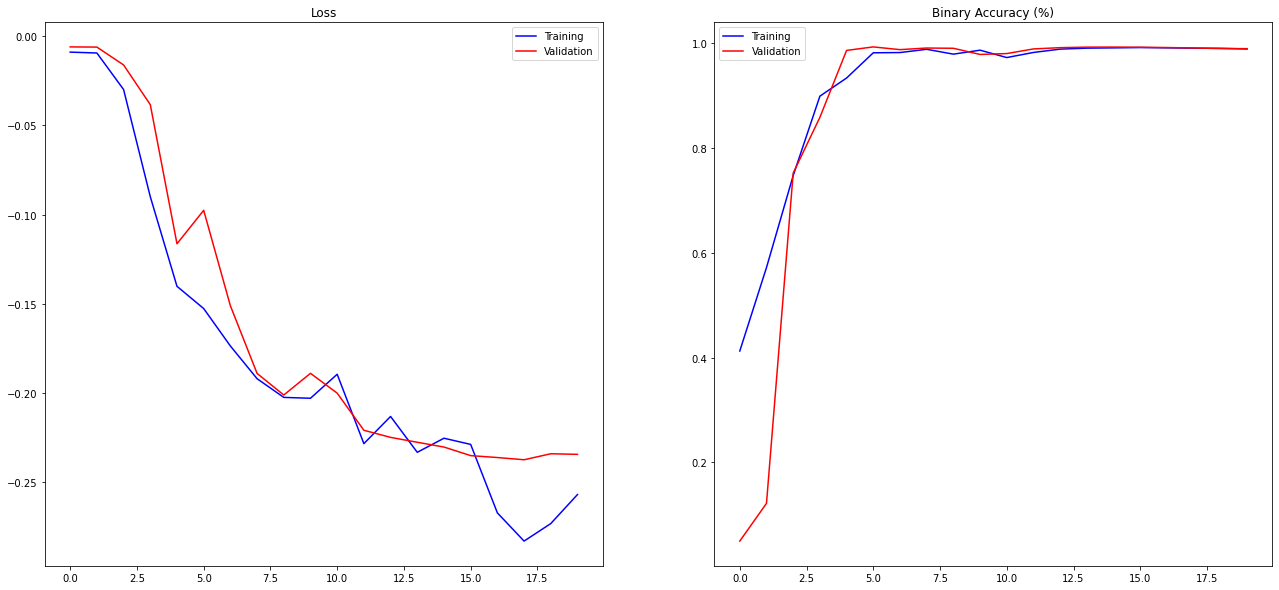

In [40]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')

show_loss(loss_history)

In [41]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')

In [42]:
pred_y = seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

(900, 256, 256, 1) 0.0 1.8924215e-08 0.007895555


In [44]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save('fullres_model.h5')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


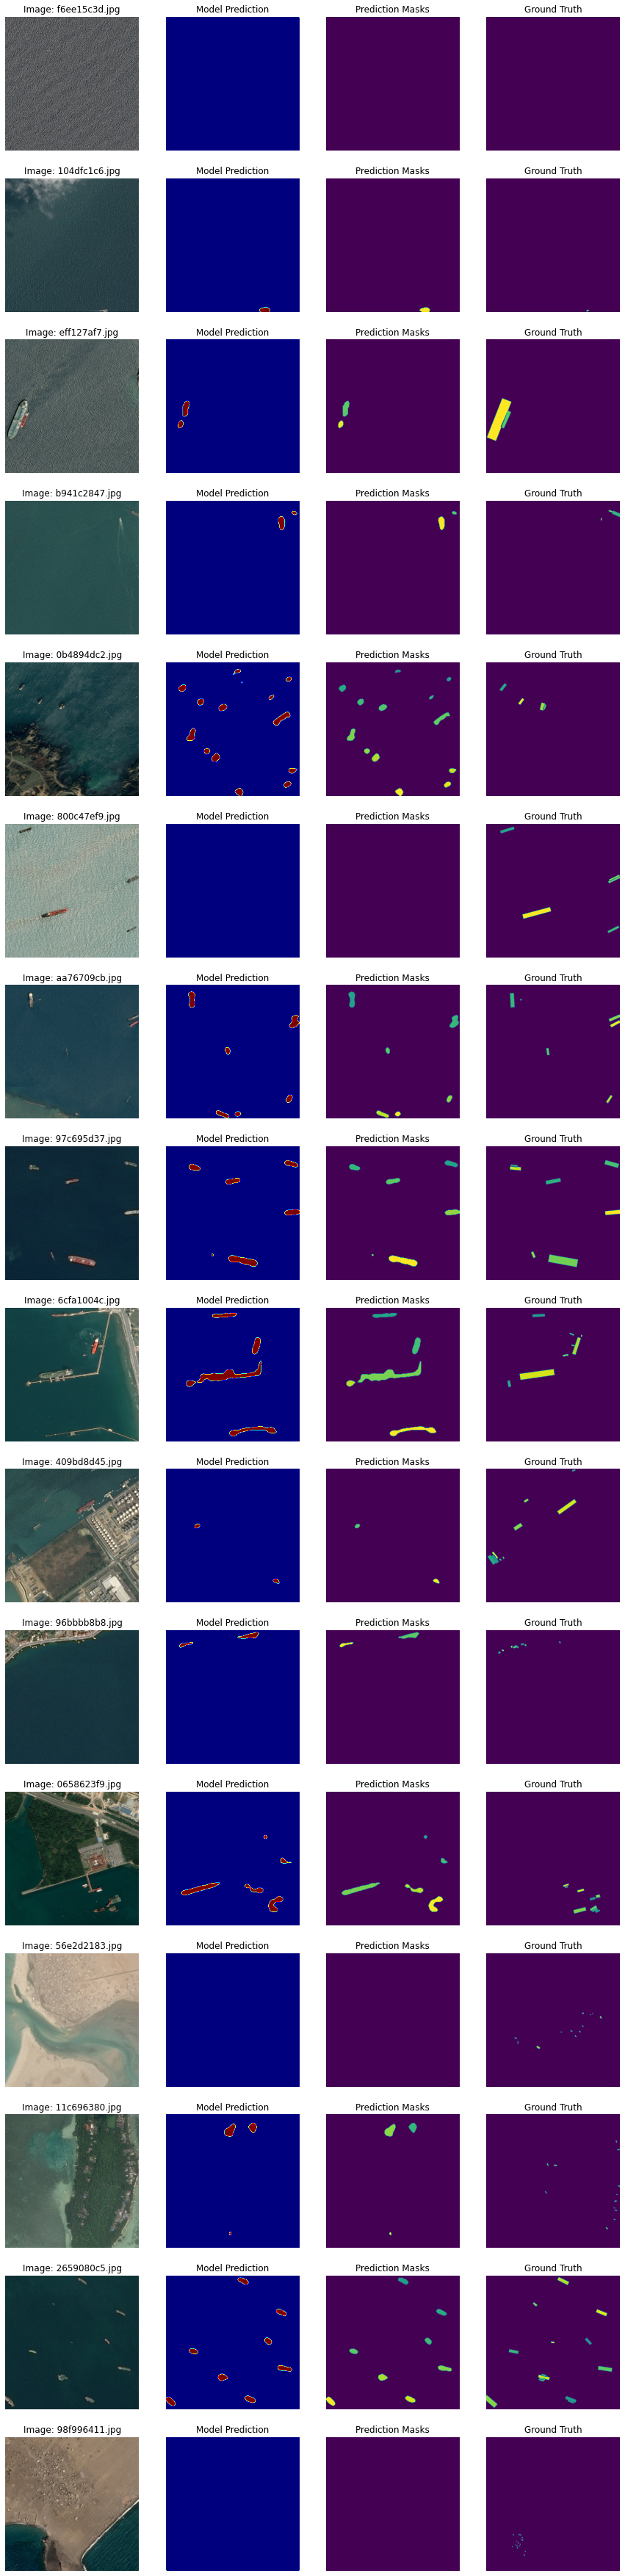

In [45]:
def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('validation.png')

In [46]:
test_paths = np.array(os.listdir(test_image_dir))
print(len(test_paths), 'test images found')

15606 test images found


In [48]:
from tqdm import tqdm_notebook

def pred_encode(img, **kwargs):
    cur_seg, _ = predict(img)
    cur_rles = multi_rle_encode(cur_seg, **kwargs)
    return [[img, rle] for rle in cur_rles if rle is not None]

out_pred_rows = []
for c_img_name in tqdm_notebook(test_paths[:3000]): ## only a subset as it takes too long to run
    out_pred_rows += pred_encode(c_img_name, min_max_threshold=1.0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == "__main__":


  0%|          | 0/3000 [00:00<?, ?it/s]

In [49]:
sub = pd.DataFrame(out_pred_rows)
sub.columns = ['ImageId', 'EncodedPixels']
sub = sub[sub.EncodedPixels.notnull()]
sub.head()

,ImageId,EncodedPixels
0,b0808caaf.jpg,193986 11 194753 13 195520 15 196287 17 197054...
1,51ffc3d65.jpg,514428 2 515195 4 515962 6 516730 7 517498 8 5...
2,08229754b.jpg,332235 11 333002 13 333769 15 334524 35 335291...
3,08229754b.jpg,569541 8 570308 10 571075 12 571836 26 572603 ...
4,36cc4738f.jpg,198210 2 198977 4 199744 6 200511 8 201278 10 ...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


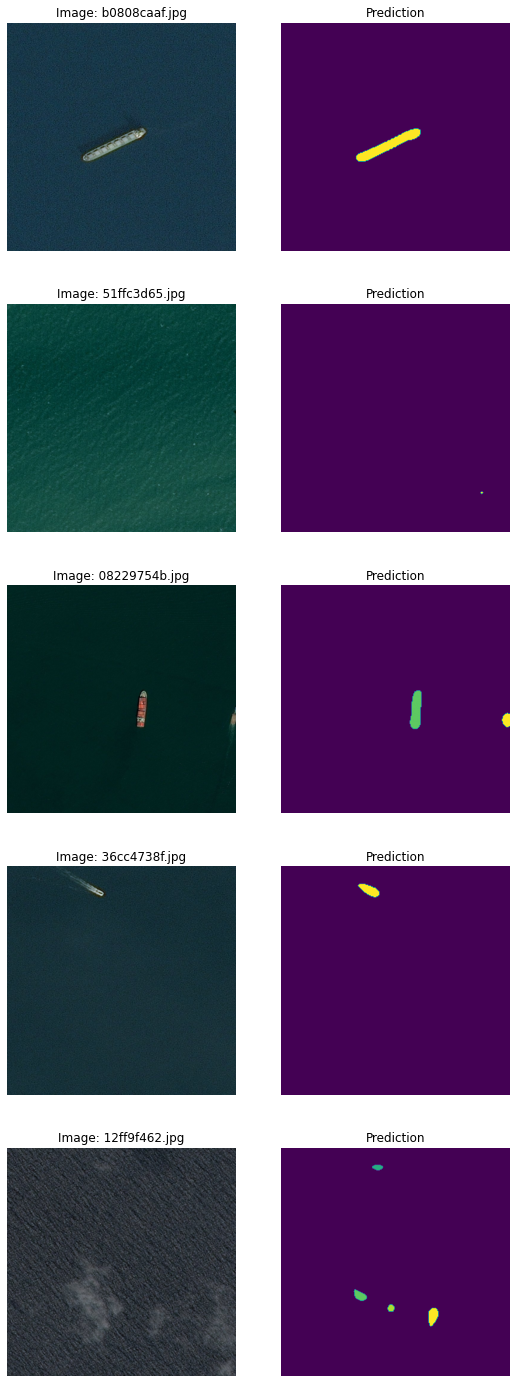

In [50]:
TOP_PREDICTIONS=5
fig, m_axs = plt.subplots(TOP_PREDICTIONS, 2, figsize = (9, TOP_PREDICTIONS*5))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2), c_img_name in zip(m_axs, sub.ImageId.unique()[:TOP_PREDICTIONS]):
    c_img = imread(os.path.join(test_image_dir, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    ax1.imshow(c_img[0])
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(masks_as_color(sub.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels']))
    ax2.set_title('Prediction')

In [51]:
sub.to_csv('submission.csv', index=False)
sub.sample(3)

,ImageId,EncodedPixels
3069,4b400f03e.jpg,405855 2 406622 4 407389 6 408156 8 408923 10 ...
552,137d012d7.jpg,97008 2 97775 4 98542 6 99310 7 100078 8 10084...
1144,4eb5ed478.jpg,45227 1 45994 3 46758 11 47525 13 48292 15 490...
